In [1]:

import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr
import atlite

import logging
import warnings

warnings.simplefilter("ignore")
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

shpfilename = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_0_countries"
)
reader = shpreader.Reader(shpfilename)
UkIr = gpd.GeoSeries(
    {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
    crs={"init": "epsg:4326"},
).reindex(["United States"])

In [4]:
cutout = atlite.Cutout(
    path="/Users/kamrantehranchi/Local_Documents/pypsa-breakthroughenergy-usa/workflow/resources/western/cutout_western_ERA5.nc",
)

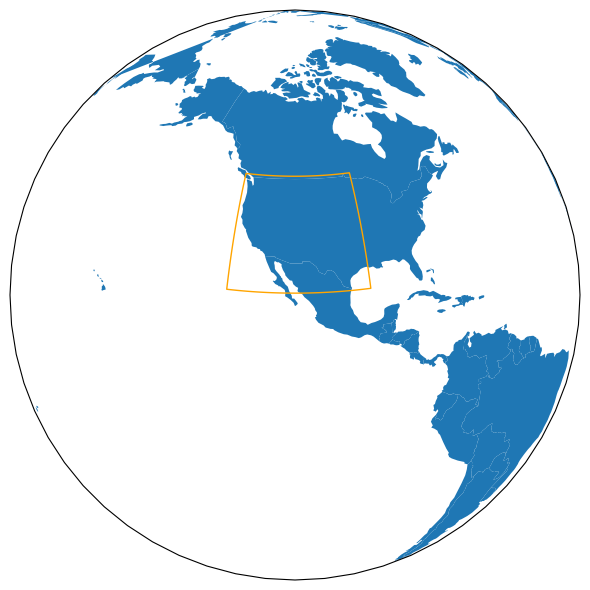

In [7]:
cells = cutout.grid
df = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
country_bound = gpd.GeoSeries(cells.unary_union)

projection = ccrs.Orthographic(-110, 25)
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(6, 6))
df.plot(ax=ax, transform=plate())
country_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
fig.tight_layout()

type: aspect must be finite and positive 

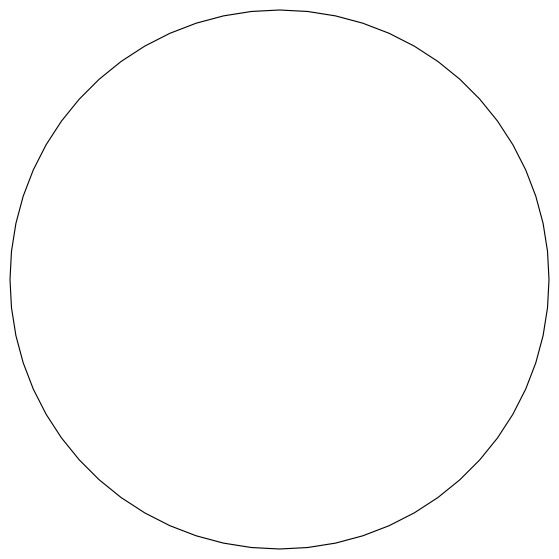

In [14]:
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
plot_grid_dict = dict(
    alpha=0.1,
    edgecolor="k",
    zorder=4,
    aspect="equal",
    facecolor="None",
    transform=plate(),
)
UkIr.plot(ax=ax, zorder=1, transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
country_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
ax.outline_patch.set_edgecolor("white")

ax1 = fig.add_subplot(gs[0, 2])
cutout.data.wnd100m.mean(["x", "y"]).plot(ax=ax1)
ax1.set_frame_on(False)
ax1.xaxis.set_visible(False)

ax2 = fig.add_subplot(gs[1, 2], sharex=ax1)
cutout.data.influx_direct.mean(["x", "y"]).plot(ax=ax2)
ax2.set_frame_on(False)
ax2.xaxis.set_visible(False)

ax3 = fig.add_subplot(gs[2, 2], sharex=ax1)
cutout.data.runoff.mean(["x", "y"]).plot(ax=ax3)
ax3.set_frame_on(False)
ax3.set_xlabel(None)
fig.tight_layout()

INFO:atlite.convert:Convert and aggregate 'wind'.


[########################################] | 100% Completed | 118.46 s


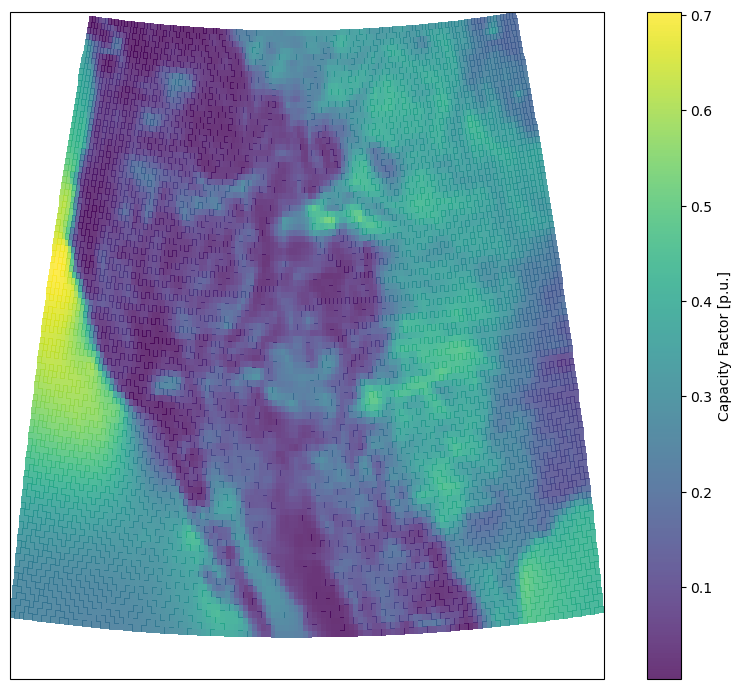

In [18]:
cap_factors = cutout.wind(turbine="Vestas_V112_3MW", capacity_factor=True)

fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(9, 7))
cap_factors.name = "Capacity Factor"
cap_factors.plot(ax=ax, transform=plate(), alpha=0.8)
cells.plot(ax=ax, **plot_grid_dict)
# ax.outline_patch.set_edgecolor("white")
fig.tight_layout();

In [16]:
sites = gpd.GeoDataFrame(
    [
        ["london", 0.7, 51.3, 20],
        ["dublin", -6.16, 53.21, 30],
        ["edinburgh", -3.13, 55.5, 10],
    ],
    columns=["name", "x", "y", "capacity"],
).set_index("name")

nearest = cutout.data.sel({"x": sites.x.values, "y": sites.y.values}, "nearest").coords
sites["x"] = nearest.get("x").values
sites["y"] = nearest.get("y").values
cells_generation = sites.merge(cells, how="inner").rename(pd.Series(sites.index))

layout = (
    xr.DataArray(cells_generation.set_index(["y", "x"]).capacity.unstack())
    .reindex_like(cap_factors)
    .rename("Installed Capacity [MW]")
)

fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(9, 7))

UkIr.plot(ax=ax, zorder=1, transform=plate(), alpha=0.3)
cells.plot(ax=ax, **plot_grid_dict)
layout.plot(
    ax=ax, transform=plate(), cmap="Reds", vmin=0, label="Installed Capacity [MW]"
)
ax.outline_patch.set_edgecolor("white")
fig.tight_layout()

fig, axes = plt.subplots(len(sites), sharex=True, figsize=(9, 4))
power_generation = cutout.wind(
    "Vestas_V112_3MW", layout=layout, shapes=cells_generation.geometry
)

power_generation.to_pandas().plot(subplots=True, ax=axes)
axes[2].set_xlabel("date")
axes[1].set_ylabel("Generation [MW]")
fig.tight_layout()

type: Index contains duplicate entries, cannot reshape

type: Length of values (2) does not match length of index (1)

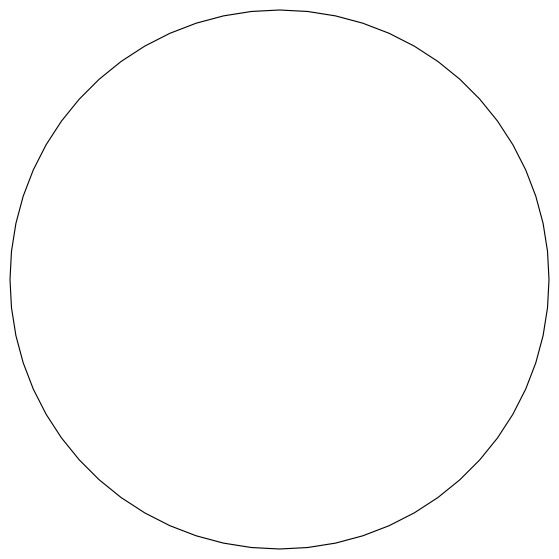

In [17]:
from shapely.geometry import Point

fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
df = gpd.GeoDataFrame(UkIr, columns=["geometry"]).assign(color=["1", "2"])
df.plot(column="color", ax=ax, zorder=1, transform=plate(), alpha=0.6)

sites.assign(geometry=sites.apply(lambda ds: Point(ds.x, ds.y), axis=1)).plot(
    ax=ax, zorder=2, transform=plate(), color="indianred"
)

ax.outline_patch.set_edgecolor("white")

power_generation = (
    cutout.wind("Vestas_V112_3MW", layout=layout.fillna(0), shapes=UkIr)
    .to_pandas()
    .rename_axis(index="", columns="shapes")
)

ax1 = fig.add_subplot(gs[1, 2])
power_generation["Ireland"].plot.area(ax=ax1, title="Ireland", color="indianred")
ax2 = fig.add_subplot(gs[2, 2])
power_generation["United Kingdom"].plot.area(
    ax=ax2, title="United Kingdom", color="darkgreen"
)

ax2.set_xlabel("date")
[ax.set_ylabel("Generation [MW]") for ax in [ax1, ax2]]

fig.tight_layout()